In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
from control.matlab import *
import cvxpy as cp
import math
import pandas as pd
import itertools
ct.use_fbs_defaults()

In [2]:
def set_subplot(ax, x_data, y_data, xlabel, ylabel, title, line_color='#120a8f', linewidth=1.5):
  line, = ax.plot(x_data, y_data, linestyle='-',
                  color=line_color, linewidth=linewidth)
  ax.set_xlabel(xlabel, fontsize=18)
  ax.set_ylabel(ylabel, fontsize=18)
  ax.grid(linestyle='--')
  ax.set_title(title, fontsize=20)
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=16)

  return line


def show_matrix(matrix, name='ans', decimal_places=2, scientific_notation=True):
  """
  Apresenta uma matriz com a quantidade de casas decimais desejadas.

  Parâmetros:
  ---
  - matrix: numpy.ndarray, a matriz a ser apresentada.
  - casas_decimais: int, o número de casas decimais desejadas (padrão é 2).
  """
  pattern = "{:." + str(decimal_places) + \
      ("e}" if scientific_notation else "f}")

  def format_elem(elem):
    return pattern.format(elem)

  width = [max(map(len, map(format_elem, coluna))) for coluna in matrix.T]

  print(name, "=")

  nspaces = sum(width) + 2 * matrix.shape[1]

  print("    ┌" + " " * nspaces + "┐")
  for line in matrix:
    formatted_line = "  ".join(format_elem(e).rjust(largura)
                               for e, largura in zip(line, width))
    print("    │ " + formatted_line + " │")
  print("    └" + " " * nspaces + "┘")
  print()

In [3]:
def update(t, x, u, params):
  L1 = params['L1']
  L2 = params['L2']
  LK = params['LK']
  R11 = params['R11']
  R12 = params['R12']
  R21 = params['R21']
  R22 = params['R22']
  RK = params['RK']
  C1 = params['C1']
  C2 = params['C2']
  CK = params['CK']
  RCRL = params['RCRL']

  # IB_O = params['IB_O']
  # V_IN1 = params['V_IN1']
  # V_IN2 = params['V_IN2']
  # VG_O = params['VG_O']
  # VC1_O = params['VC1_O']
  # VCK_O = params['VCK_O']
  # PCPL_OP = params['PCPL_OP']

  REQ = (R12 * R22) / (R12 + R22)

  IL1, IL2, ILK, VC1, VC2, VCK = x
  D1, V_IN2, D2, PCPL, V_IN1, IB = u

  DOT_IL1 = - (R11 / L1) * IL1 - (1 / L1) * VC1 + (V_IN1 / L1) * D1

  DOT_IL2 = - (R21 / L2) * IL2 - (1 / L2) * (1 - D2) * \
      VC2 + (1 / L2) * V_IN2

  DOT_ILK = - ((RK + REQ) / LK) * ILK - (1 / LK) * \
      VCK + (REQ / (R12 * LK)) * VC1 + \
      (REQ / (R22 * LK)) * VC2 - (REQ / LK) * IB

  DOT_VC1 = (1 / C1) * IL1 - (1 / (R12 * C1)) * (1 - (REQ / R12)) * \
      VC1 + (1 / (C1 * (R12 + R22))) * VC2 - \
      (REQ / (R12 * C1)) * IB - (REQ / (R12 * C1)) * ILK

  DOT_VC2 = (1 / C2) * (1 - D2) * IL2 - (1 / (R22 * C2)) * (1 - (REQ / R22)) * VC2 + \
      (1 / (C2 * (R12 + R22))) * VC1 - \
      (REQ / (R22 * C2)) * IB - (REQ / (R22 * C2)) * ILK

  DOT_VCK = (1 / CK) * ILK - (1 / (RCRL * CK)) * VCK - (1 / CK) * (PCPL / VCK)

  DOT_X = [DOT_IL1, DOT_IL2, DOT_ILK, DOT_VC1, DOT_VC2, DOT_VCK]

  return np.array(DOT_X)


def output(t, x, u, params):
  return x


system = ct.ss(update, output, name='microgrid',
               inputs=('D1', 'V_IN2', 'D2', 'PCPL', 'V_IN1', 'IB'),
               states=('IL1', 'IL2', 'ILK', 'VC1', 'VC2', 'VCK'),
               outputs=('IL1', 'IL2', 'ILK', 'VC1', 'VC2', 'VCK'))

print(system)

<NonlinearIOSystem>: microgrid
Inputs (6): ['D1', 'V_IN2', 'D2', 'PCPL', 'V_IN1', 'IB']
Outputs (6): ['IL1', 'IL2', 'ILK', 'VC1', 'VC2', 'VCK']
States (6): ['IL1', 'IL2', 'ILK', 'VC1', 'VC2', 'VCK']

Update: <function update at 0x7c8693f52ef0>
Output: <function output at 0x7c8693f52f80>


In [4]:
L1 = L2 = LK = 1e-3
R11 = R12 = R21 = R22 = RK = 0.1
C1 = C2 = CK = 2.2e-3
RCRL = 20

VE_O = 24

IB_O = 14
V_IN1 = 36
V_IN2 = 12
VC1_O = 24
VCK_O = 20
PCPL_OP = 50

params = {
    # Parâmetros da Geração
    'L1': L1,
    'R11': R11,
    'C1': C1,
    'R12': R12,

    # Parâmetros da Bateria
    'L2': L2,
    'R21': R21,
    'C2': C2,
    'R22': R22,

    # Parâmetros da Carga
    'LK': LK,
    'RK': RK,
    'CK': CK,
    'RCRL': RCRL,

    'OP': {
        'IB_O': IB_O,
        'V_IN1': V_IN1,
        'V_IN2': V_IN2,
        'VC1_O': VC1_O,
        'VCK_O': VCK_O,
        'PCPL_OP': PCPL_OP,
    }
}


REQ = (R12 * R22) / (R12 + R22)

ILK_O = VCK_O / RCRL + PCPL_OP / VCK_O
VC2_O = ((R22 * (RK + REQ)) / REQ) * ILK_O + (R22 / REQ) * \
    VCK_O - (R22 / R12) * VC1_O + R22 * IB_O

print(VC2_O)

a = R21 / VC2_O
b = - V_IN2 / VC2_O
c = -((1 / R22) * (1 - (REQ / R22)) *
      VC2_O + (REQ / R22) * ILK_O - (1 / (R12 + R22)) * VC1_O + (REQ / R22) * IB_O)

delta = b**2 - 4 * a * c
print(delta)
x1 = (-b + math.sqrt(delta)) / (2 * a)
x2 = (-b - math.sqrt(delta)) / (2 * a)
print(x1, x2)

IL2_O = x1
D2_O = 1 + (R21 * IL2_O) / VC2_O - V_IN2 / VC2_O
print(D2_O)

IL1_O = (1 / R12) * (1 - (REQ / R12)) * \
    VC1_O + (REQ / R12) * ILK_O - (1 / (R12 + R21)) * \
    VC2_O + (REQ / R12) * IB_O
D1_O = R11 / V_IN1 * IL1_O + VC1_O / V_IN1

print(f'\nVC1_O: {VC1_O}')
print(f'IL1_O: {IL1_O}')
print(f'D1_O: {D1_O}')

print(f'\nVC2_O: {VC2_O}')
print(f'IL2_O: {IL2_O}')
print(f'D2_O: {D2_O}')


U = [D1_O, V_IN2, D2_O, PCPL_OP, V_IN1, IB_O]
X = 0.95 * np.array([IL1_O, IL2_O, ILK_O, VC1_O, VC2_O, VCK_O])
end_time = 2e-1
step = 1e-5

# Instantes de tempo
timepts = np.arange(0, end_time + step, step)

18.44999999999999
0.011104501288914104
69.72111104761125 50.278888952388755
0.7274856967350201

VC1_O: 24
IL1_O: 36.50000000000003
D1_O: 0.7680555555555556

VC2_O: 18.44999999999999
IL2_O: 69.72111104761125
D2_O: 0.7274856967350201


In [5]:
t, y = ct.input_output_response(
    sys=system, T=timepts,
    U=U, X0=X, params=params,
)

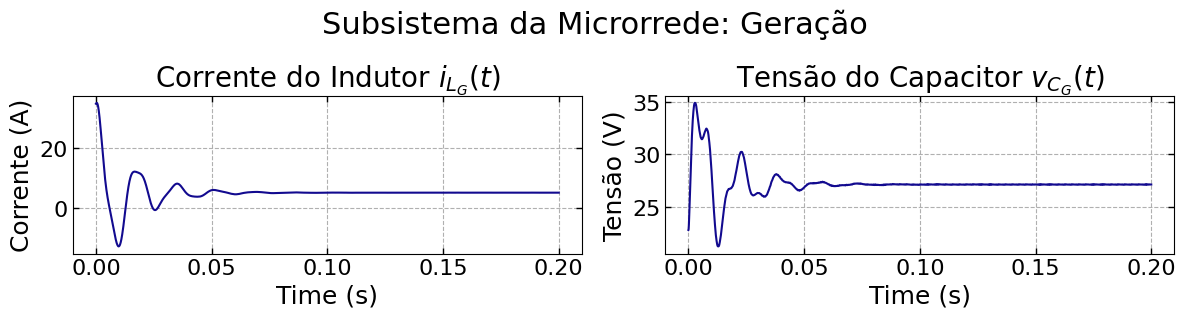

In [8]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3.2))

# Adicionando o título à figura
fig.suptitle("Subsistema da Microrrede: Geração", fontsize=22)

set_subplot(
    axs[0], t, y[2],
    'Time (s)', 'Corrente (A)', 'Corrente do Indutor $i_{L_G}(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1],  t, y[5],
    'Time (s)', 'Tensão (V)', 'Tensão do Capacitor $v_{C_G}(t)$',
)

plt.tight_layout()
plt.close()

In [7]:
# Parâmetros (Fuzzy)

def z1(x, u):
  VCK = x[system.state_labels['VCK']]
  return 1. / (CK * VCK_O * (VCK_O + VCK))


def z2(x, u):
  return u[system.state_labels['V_IN1']]


def z3(x, u):
  return x[system.state_labels['VC2']]


def z4(x, u):
  return x[system.state_labels['IL2']]


z = [z1, z2, z3, z4]
VCK_MIN = 16
VCK_MAX = 24
VIN1_MIN = 46
VIN1_MAX = 50
VC2_MIN = 16
VC2_MAX = 24
IL2_MIN = 89
IL2_MAX = 98

z_bounds = [
    [1. / (CK * VCK_O * VCK_MAX), 1. / (CK * VCK_O * VCK_MIN)],
    [VIN1_MIN - V_IN1, VIN1_MAX - V_IN1],
    [VC2_MIN - VC2_O, VC2_MAX - VC2_O],
    [IL2_MIN - IL2_O, IL2_MAX - IL2_O],
]

show_matrix(np.array(z_bounds))

A = {}
B = {}
E = {}
K_TIL = {}

B4 = list(itertools.product([0, 1], repeat=4))

for i in B4:
  A11 = - (R11 / L1)
  A14 = - (1. / L1)
  A22 = - (R21 / L2)
  A25 = - ((R11 * IL2_O) / (L2 * VC2_O)) + V_IN2 / (L2 * VC2_O)
  A33 = - (RK + REQ) / LK
  A34 = REQ / (R12 * LK)
  A35 = REQ / (R22 * LK)
  A35 = - 1 / LK
  A41 = 1. / C1
  A43 = - (REQ / (R12 * C1))
  A44 = - (1. / (R12 * C1)) * (1. - (REQ / R12))
  A45 = 1. / (C1 * (R12 + R22))
  A52 = (1. / C2) * (1 - D2_O)
  A53 = - (REQ / (R12 * C2))
  A54 = 1. / (C2 * (R12 + R22))
  A55 = - (1. / (R22 * C1)) * (1. - (REQ / R12))
  A63 = 1. / CK

  A66 = PCPL_OP * z_bounds[0][i[0]] - 1. / (RCRL * CK)

  A[i] = cp.Parameter((6, 6), value=np.array([[A11, 0.0, 0.0, A14, 0.0, 0.0],
                                              [0.0, A22, 0.0, 0.0, A25, 0.0],
                                              [0.0, 0.0, A33, A34, A35, 0.0],
                                              [A41, 0.0, A43, A44, A45, 0.0],
                                              [0.0, A52, A53, A54, A55, 0.0],
                                              [0.0, 0.0, A63, 0.0, 0.0, A66]]))

  B11 = (V_IN1 + z_bounds[1][i[1]]) / L1
  B22 = (V_IN2 + z_bounds[2][i[2]]) / L2
  B33 = - (REQ / LK)
  B43 = - (REQ / (R12 * C1))
  B52 = - (1. / C2) * (IL1_O + z_bounds[3][i[3]])
  B53 = - (REQ / (R12 * C2))

  B[i] = cp.Parameter((6, 3), value=np.array([[B11, 0.0, 0.0],
                                              [0.0, B22, 0.0],
                                              [0.0, 0.0, B33],
                                              [0.0, 0.0, B43],
                                              [0.0, B52, B53],
                                              [0.0, 0.0, 0.0]]))

  F11 = (1. / L1) * ((R11 / V_IN1) * IL1_O + (1. / V_IN1) * VC1_O)
  F22 = 1. / L2
  F63 = VCK_O * z_bounds[0][i[0]]

  E[i] = cp.Parameter((6, 3), value=np.array([[F11, 0.0, 0.0],
                                             [0.0, F22, 0.0],
                                              [0.0, 0.0, 0.0],
                                              [0.0, 0.0, 0.0],
                                              [0.0, 0.0, 0.0],
                                              [0.0, 0.0, F63]]))

  K_TIL[i] = cp.Variable((3, 6), name=f'K{i}')

Ξ_TIL = cp.Variable((6, 6), name='Ξ_TIL', PSD=True)
Ψ_TIL = cp.Variable((6, 6), name='Ψ_TIL', PSD=True)
X = cp.Variable((6, 6), name='X', PSD=True)

print(B[(0, 0, 0, 1)].name)
constraints = []

I6 = np.eye(6)
Z6 = np.zeros((6, 6))

for i in B4:
  for j in B4:
    Y11 = He(A[i] @ X + B[i] @ K_TIL[j]) + I6
    Y12 = B[i] @ K_TIL[j]
    Y13 = E[i] @ X
    Y22 = -Ξ_TIL
    Y23 = Z6

ans =
    ┌                     ┐
    │  9.47e-01  1.42e+00 │
    │  1.00e+01  1.40e+01 │
    │ -2.45e+00  5.55e+00 │
    │  1.93e+01  2.83e+01 │
    └                     ┘

<bound method Parameter.name of Parameter((6, 3))>


NameError: name 'He' is not defined

In [ ]:
def He(M):
  return M + M.T


# Define the parameters for the optimization problem
A = cp.Parameter((2, 2), value=linearized_buck_converter.system.A)
BU = cp.Parameter((2, 1), value=linearized_buck_converter.system.B[:, 0])
I = cp.Parameter((2, 2), name='I', value=np.identity(2))

# Define the variables for the optimization problem
Ξ_TIL = cp.Variable((2, 2), name='Ξ_TIL', PSD=True)
Ψ_TIL = cp.Variable((2, 2), name='Ψ_TIL', PSD=True)
X = cp.Variable((2, 2), name='X', PSD=True)
K_TIL = cp.Variable((1, 2), name='K_TIL')

_lambda = .5

# Define the objective function and constraints
obj = cp.Minimize(cp.trace(_lambda * Ξ_TIL + (1 - _lambda) * Ψ_TIL))

# Define the matrix blocks for the LMI constraint
M11 = A @ X + BU @ K_TIL + X @ A.T + K_TIL.T @ BU.T
M12 = BU @ K_TIL
M13 = X

M21 = K_TIL.T @ BU.T
M22 = -Ξ_TIL
M23 = np.zeros(shape=(2, 2))

M31 = X
M32 = np.zeros(shape=(2, 2))
M33 = -Ψ_TIL

# Combine the matrix blocks into a single matrix for the LMI constraint
M = cp.bmat([[M11, M12, M13],
             [M21, M22, M23],
             [M31, M32, M33]])

# Print the shape of the combined matrix
print(M.shape)

# Define the constraints
constraints = [M << 0]
constraints += [1e-9 * np.eye(2) <= Ξ_TIL]
constraints += [Ξ_TIL <= 1e9 * np.eye(2)]
constraints += [1e-9 * np.eye(2) <= Ψ_TIL]
constraints += [Ψ_TIL <= 1e9 * np.eye(2)]

# Define the optimization problem
prob = cp.Problem(obj, constraints)

# Solve the problem using the MOSEK solver
prob.solve(solver=cp.MOSEK, verbose=False)

# Initialize variables to store results
K = None
Ξ = None
Ψ = None

# Display the results
if prob.status not in ["infeasible", "unbounded"]:
  print("Optimal value: %s\n" % prob.value)
  for variable in prob.variables():
    if len(variable.shape) == 2:
      show_matrix(variable.name(), variable.value)
    else:
      print(variable.name(), '=', variable.value, '\n')

  # Compute the inverse of X and use it to calculate Ξ and K
  X_INV = np.linalg.inv(X.value)
  Ξ = X_INV @ Ξ_TIL.value @ X_INV

  _K = K_TIL @ X_INV
  K = _K.value

  show_matrix('K', K)

  Ψ = np.linalg.inv(Ψ_TIL.value)

  show_matrix('Ξ', Ξ)
  show_matrix('Ψ', Ψ)
else:
  print('The problem is not feasible')

NameError: name 'linearized_buck_converter' is not defined